# Zero-Noise Extrapolation (ZNE) with Indirect-Control System
---

This experiment is:

- Qubit: 7, layer: 30
- System has noise-free time evolution.
- Target observable: Transverse field Ising Hamiltonian.
- Ansatz time-evolution: Noise-free time-evolution with XY, Ising, and Heisenberg Hamiltonians.
- Time-constraint: True

## (1) Import and setup

In [1]:
# Standard library
import json
import os
from datetime import datetime

# Third-party
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate

In [2]:
# Set the default font to be LaTeX compliant.
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Computer Modern Roman"
plt.rcParams["text.usetex"] = True

# Set a global font size.
font_size = 11
plt.rcParams["font.size"] = font_size
plt.rcParams["axes.labelsize"] = font_size
plt.rcParams["xtick.labelsize"] = font_size
plt.rcParams["ytick.labelsize"] = font_size
plt.rcParams["legend.fontsize"] = 10

In [3]:
BASE_PATH = "data"

ZNE_MODELS = ["xy",
    "ising", 
    "heisenberg",
    "xy-ric3",
    "ising-ric3",
    "heisenberg-ric3"
]

JSON_ENDS_WITH = {
    "vqe": "_vqe.json",
    "redundant": "_redundant.json",
    "zne": "_zne.json",
    "noiseoff": "_noise_off.json"
}

plot_colors = [
    "darkred",
    "darkgreen",
    "darkblue",
    "darkmagenta",
    "darkcyan",
    "magenta",
    "green",
    "goldenrod",
    "black",
    "orange",
    "purple"
]

time_stamp: bool = True

## (2) Loading the experimental data from JSON files

The raw experimenal data are availabe at `data\` folder

In [4]:
# Storage
ALL_RAW_DATA = {
    model: {key: [] for key in JSON_ENDS_WITH}
    for model in ZNE_MODELS
}

# Load loop
for model in ZNE_MODELS:
    model_path = os.path.join(BASE_PATH, model)
    if not os.path.isdir(model_path):
        print(f"[WARNING] Skipping missing dir: {model_path}")
        continue
    
    for filename in os.listdir(model_path):
        if not filename.endswith(".json"):
            continue
        
        filepath = os.path.join(model_path, filename)
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[ERROR] {filepath}: {e}")
            continue
        
        filename_lower = filename.lower()
        for key, suffix in JSON_ENDS_WITH.items():
            if filename_lower.endswith(suffix):
                ALL_RAW_DATA[model][key].append(data)
                break

## (3) Extracting data

<img src="../../figures/quantum_cicuit_standard_vs_redundant.jpg" alt="std_vs_redun_circuit" width="800"/>


Now lets extract some unformations.

### (A) The exact minimum eigen value

Our target Hamiltonian is

$$H_{Ising} = \sum_{k=1}^{N-1} X_{k}X_{k+1} + \sum_{k=1}^{N}Z_k$$

where $N=7$.

The exact minimum eigen value of the target observable (i.e. tranverse field Ising Hamiltonian for a 7-qubit system) is $-8.566772233505624$. This value is recored in `file_name_prefix_ZNE.json` files.

In [5]:
EXACT_SOL: float = -8.566772233505624
EXTRAPOL_TARGET = 0.0  # Extrapolated noise level
print(f"Exact solution: {EXACT_SOL}")

Exact solution: -8.566772233505624


### (B) VQE estimations (noise is on)

The noise level ($\lambda$) is defined as 
$$\lambda = n_R + 2 n_{CZ} + N n_T + n_Y$$

where $nR, n_{CZ}, n_T, $ and $nY$ are proportinal to number of *noisy* rotation gates, two-qubit $CZ$ gate, the time-evolution gates, and Y gates. For the above circuit in the standard circuit (i.e. unboosted noise) noise level is $6$ while in the redundant circuit (i.e. boosted noise) noise level is $18$.

### (C) Processing raw data

In [6]:
ALL_PROCESSED_DATA = {
    model: {
        "vqe": {},
        "redundant": {},
        "zne": {},
        "noiseoff": {}
    } for model in ZNE_MODELS
}

for model in ZNE_MODELS:
    
    ALL_PROCESSED_DATA[model]["vqe"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["vqe"][0]["output"]["optimized_minimum_cost"]
        )
    }
    # Based off the ZNE model, length of data points can be arbitrary
    n_levels = len(ALL_RAW_DATA[model]["redundant"][0]["output"]["data_points"])
    ALL_PROCESSED_DATA[model]["redundant"] = {
        "sorted_noise_levels": ALL_RAW_DATA[model]["zne"][0]["output"]["zne_values"]["others"]["sorted_noise"],
        "mean": [
            np.mean([
                ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][level][4]
                for i in range(len(ALL_RAW_DATA[model]["redundant"]))
            ])
            for level in range(n_levels)
        ],
        "std": [
            np.std([
                ALL_RAW_DATA[model]["redundant"][i]["output"]["data_points"][level][4]
                for i in range(len(ALL_RAW_DATA[model]["redundant"]))
            ])
            for level in range(n_levels)
        ],
    }
   
    ALL_PROCESSED_DATA[model]["zne"] = {
        "mean": np.mean(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"] for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        ),
        "std": np.std(
            [ALL_RAW_DATA[model]["zne"][i]["output"]["zne_values"]["extrapolated_value"] for i in range(len(ALL_RAW_DATA[model]["zne"]))]
        )
    }

    ALL_PROCESSED_DATA[model]["noiseoff"] = {
        "mean": np.mean(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        ),
        "std": np.std(
            ALL_RAW_DATA[model]["noiseoff"][0]["output"]["optimized_minimum_cost"]
        )
    }


In [7]:
# Prepare rows for tabulation
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['sorted_noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:  # ignore empty "noiseoff"
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])

# Print table
headers = ["Model", "Category", "Mean", "Std"]
print(tabulate(rows, headers=headers))

Model            Category                  Mean       Std
---------------  --------------------  --------  --------
xy               vqe                   -7.37909  0.140519
xy               redundant (noise=6)   -7.37909  0.140519
xy               redundant (noise=18)  -5.82492  0.147749
xy               zne                   -8.15618  0.143165
xy               noiseoff              -8.36934  0.15125
ising            vqe                   -6.58315  0.189154
ising            redundant (noise=6)   -6.58315  0.189154
ising            redundant (noise=18)  -5.38044  0.211325
ising            zne                   -7.18451  0.180742
ising            noiseoff              -7.28002  0.24691
heisenberg       vqe                   -6.05646  0.180696
heisenberg       redundant (noise=6)   -6.05646  0.180696
heisenberg       redundant (noise=18)  -4.59153  0.172279
heisenberg       zne                   -6.78892  0.194212
heisenberg       noiseoff              -6.92055  0.197668
xy-ric3         

## (4) Plot

Finally we can plot the results.

In [8]:
# Stores all pplt figures
ALL_PLOTS = []
# Add timestamp if required
timestamp = ""
if time_stamp:
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

### (A) xy-ric2 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


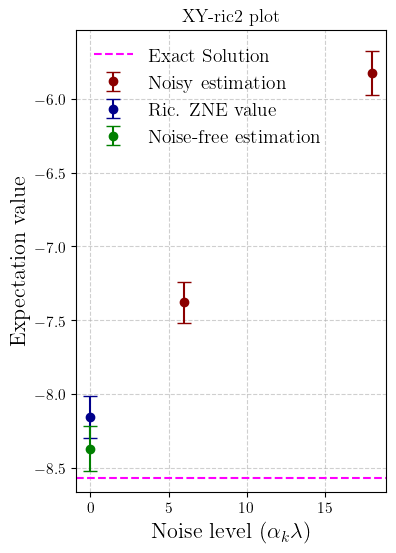

Figure saved as (in 'plots' folder): xy_ric2_20251006-130356.eps


In [9]:
# PLot parameters
plt.figure(figsize=(4, 6))
plot_title: str= "XY-ric2 plot"
plot_file_name: str= f"xy_ric2_{timestamp}.eps"
DATA= ALL_PROCESSED_DATA["xy"]

# Noisy estimation
plt.errorbar(
    x=DATA["redundant"]["sorted_noise_levels"],
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=EXTRAPOL_TARGET, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=EXACT_SOL, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_title)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_file_name}", format="eps")
ALL_PLOTS.append(plt.gcf())
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_file_name)

### (B) ising-ric2 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


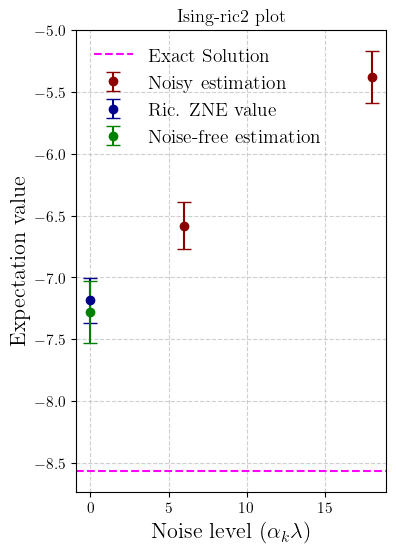

Figure saved as (in 'plots' folder): ising_ric2_20251006-130356.eps


In [10]:
# PLot parameters
plt.figure(figsize=(4, 6))
plot_title: str= "Ising-ric2 plot"
plot_file_name: str= f"ising_ric2_{timestamp}.eps"
DATA= ALL_PROCESSED_DATA["ising"]

# Noisy estimation
plt.errorbar(
    x=DATA["redundant"]["sorted_noise_levels"],
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=EXTRAPOL_TARGET, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=EXACT_SOL, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_title)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_file_name}", format="eps")
ALL_PLOTS.append(plt.gcf())
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_file_name)

### (C) heisenberg-ric2 plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


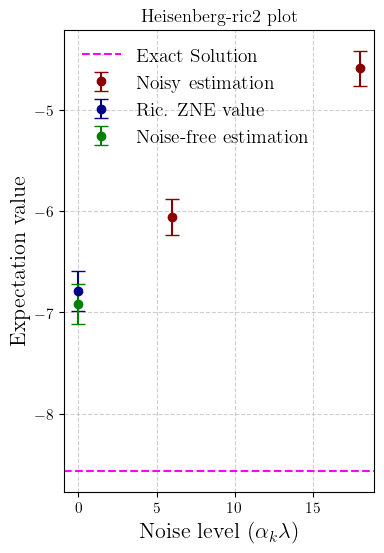

Figure saved as (in 'plots' folder): heisenberg_ric2_20251006-130356.eps


In [11]:
# PLot parameters
plt.figure(figsize=(4, 6))
plot_title: str= "Heisenberg-ric2 plot"
plot_file_name: str= f"heisenberg_ric2_{timestamp}.eps"
DATA= ALL_PROCESSED_DATA["heisenberg"]

# Noisy estimation
plt.errorbar(
    x=DATA["redundant"]["sorted_noise_levels"],
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=EXTRAPOL_TARGET, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="o", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=EXACT_SOL, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_title)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_file_name}", format="eps")
ALL_PLOTS.append(plt.gcf())
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_file_name)

### (D) Compiled ric-2 plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


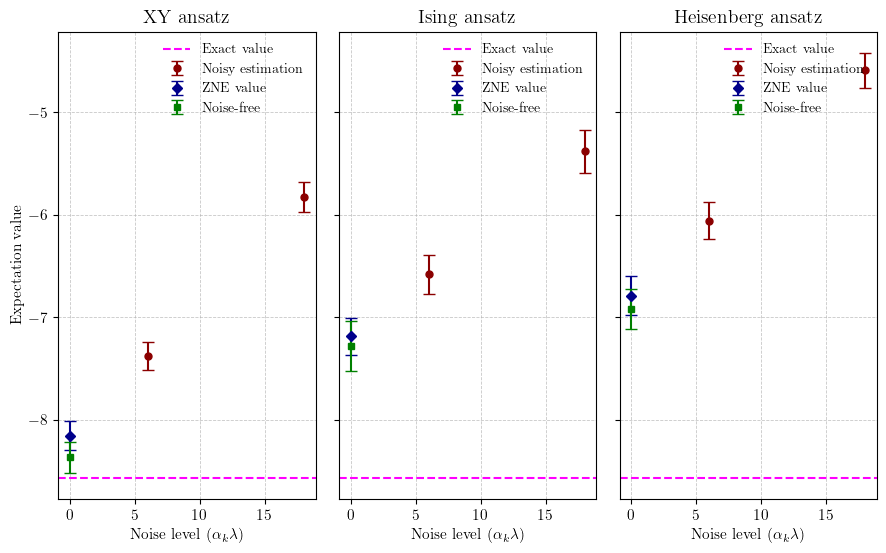

In [12]:
plot_name: str = f"compiled_ric2_ansatz_noise_free_tevo_{timestamp}.eps"
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 6), sharey=True)

plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}

for i, model in enumerate(["xy", "ising", "heisenberg"]):
    ax = axs[i]
    DATA = ALL_PROCESSED_DATA[model]

    # Noisy Estimation
    ax.errorbar(
        x=DATA["redundant"]["sorted_noise_levels"],
        y=DATA["redundant"]["mean"],
        yerr=DATA["redundant"]["std"],
        fmt="o",
        ecolor=plot_colors[0],
        capsize=4,
        label="Noisy estimation",
        color=plot_colors[0],
        markersize=5
    )

    # ZNE Extrapolated
    ax.errorbar(
        x=EXTRAPOL_TARGET,
        y=DATA["zne"]["mean"],
        yerr=DATA["zne"]["std"],
        fmt="D",
        ecolor=plot_colors[2],
        capsize=4,
        label="ZNE value",
        color=plot_colors[2],
        markersize=5
    )

    # Noise-free Estimation
    ax.errorbar(
        x=0,
        y=DATA["noiseoff"]["mean"],
        yerr=DATA["noiseoff"]["std"],
        fmt="s",
        ecolor=plot_colors[6],
        capsize=4,
        label="Noise-free",
        color=plot_colors[6],
        markersize=5
    )

    # Exact Value
    ax.axhline(
        y=EXACT_SOL,
        color=plot_colors[5],
        linestyle="--",
        linewidth=1.5,
        label="Exact value"
    )

    # Titles and Labels
    ax.set_title(plot_titles[model], fontsize=14)
    ax.set_xlabel(r"Noise level ($\alpha_k\lambda$)")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    if i == 0:
        ax.set_ylabel("Expectation value")

    # ✅ Legend in top right
    ax.legend(loc="upper right", frameon=False)

# Layout tweaks
plt.tight_layout(w_pad=1.2, h_pad=0.3)
plt.subplots_adjust(top=0.88)

# Optional: Save
plt.savefig(f"plots/{plot_name}", format="eps")

plt.show()

### (E) xy-ric3 plot

In [13]:
ALL_PROCESSED_DATA["xy-ric3"]

{'vqe': {'mean': -7.379092083216174, 'std': 0.14051949985579798},
 'redundant': {'sorted_noise_levels': [6, 18, 26],
  'mean': [-7.409331490400592, -5.906668666189325, -5.103189370580745],
  'std': [0.1336501215544252, 0.1427676853949237, 0.15355442568794583]},
 'zne': {'mean': -8.294512648865503, 'std': 0.14483467947323103},
 'noiseoff': {'mean': -8.369342611101047, 'std': 0.15124979844206457}}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


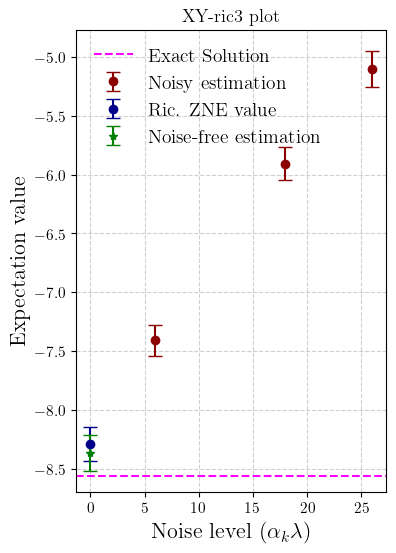

Figure saved as (in 'plots' folder): xy_ric3_20251006-130356.eps


In [14]:
# PLot parameters
plt.figure(figsize=(4, 6))
plot_title: str= "XY-ric3 plot"
plot_file_name: str= f"xy_ric3_{timestamp}.eps"
DATA= ALL_PROCESSED_DATA["xy-ric3"]

# Noisy estimation
plt.errorbar(
    x=DATA["redundant"]["sorted_noise_levels"],
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=EXTRAPOL_TARGET, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="*", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=EXACT_SOL, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_title)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_file_name}", format="eps")
ALL_PLOTS.append(plt.gcf())
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_file_name)

### (F) ising-ric3 plot

In [15]:
ALL_PROCESSED_DATA["ising-ric3"]

{'vqe': {'mean': -6.583152545992618, 'std': 0.18915423038578477},
 'redundant': {'sorted_noise_levels': [6, 18, 26],
  'mean': [-6.653021777706965, -5.532364321678951, -4.894445554216257],
  'std': [0.18398055353119, 0.21401901845523663, 0.23387671102190288]},
 'zne': {'mean': -7.294514679059577, 'std': 0.18418889110841827},
 'noiseoff': {'mean': -7.2800222505553736, 'std': 0.24690963596051196}}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


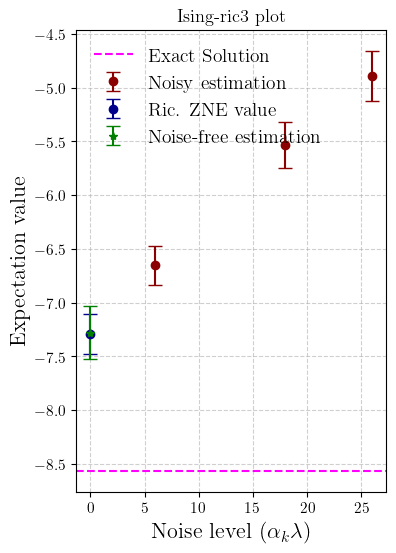

Figure saved as (in 'plots' folder): ising_ric3_20251006-130356.eps


In [16]:
# PLot parameters
plt.figure(figsize=(4, 6))
plot_title: str= "Ising-ric3 plot"
plot_file_name: str= f"ising_ric3_{timestamp}.eps"
DATA= ALL_PROCESSED_DATA["ising-ric3"]

# Noisy estimation
plt.errorbar(
    x=DATA["redundant"]["sorted_noise_levels"],
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=EXTRAPOL_TARGET, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="*", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=EXACT_SOL, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_title)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_file_name}", format="eps")
ALL_PLOTS.append(plt.gcf())
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_file_name)

### (G) heisenberg-ric3 plot

In [17]:
ALL_PROCESSED_DATA["heisenberg-ric3"]

{'vqe': {'mean': -6.056457299952753, 'std': 0.1806957231807042},
 'redundant': {'sorted_noise_levels': [6, 18, 26],
  'mean': [-6.056457299952717, -4.591528569882987, -3.80869593495965],
  'std': [0.18069572318071436, 0.17227869097031917, 0.17433124795481902]},
 'zne': {'mean': -6.919727564945707, 'std': 0.19696437844337153},
 'noiseoff': {'mean': -6.9205461139528435, 'std': 0.19766791757742266}}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


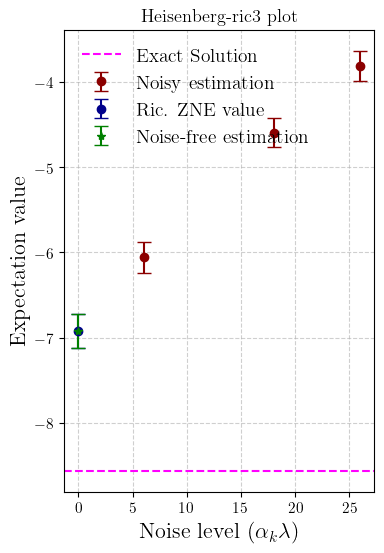

Figure saved as (in 'plots' folder): heisenberg_ric3_20251006-130356.eps


In [18]:
# PLot parameters
plt.figure(figsize=(4, 6))
plot_title: str= "Heisenberg-ric3 plot"
plot_file_name: str= f"heisenberg_ric3_{timestamp}.eps"
DATA= ALL_PROCESSED_DATA["heisenberg-ric3"]

# Noisy estimation
plt.errorbar(
    x=DATA["redundant"]["sorted_noise_levels"],
    y=DATA["redundant"]["mean"],
    yerr=DATA["redundant"]["std"], 
    fmt="o", 
    ecolor=plot_colors[0],
    capsize=5, 
    label="Noisy estimation", 
    color=plot_colors[0]
)
# Extrapolated
plt.errorbar(
    x=EXTRAPOL_TARGET, 
    y=DATA["zne"]["mean"], 
    yerr=DATA["zne"]["std"], 
    fmt="o", 
    ecolor=plot_colors[2],
    capsize=5, 
    label="Ric. ZNE value", 
    color=plot_colors[2]
)
# Noise-free 
plt.errorbar(
    x=0, 
    y=DATA["noiseoff"]["mean"], 
    yerr=DATA["noiseoff"]["std"], 
    fmt="*", 
    ecolor=plot_colors[6],
    capsize=5, 
    label="Noise-free estimation", 
    color=plot_colors[6]
)
# Exact solution
plt.axhline(y=EXACT_SOL, color=plot_colors[5], linestyle="--", label=f"Exact Solution")

# Labels and title
plt.xlabel(r"Noise level ($\alpha_k\lambda$)", fontsize=16)
plt.ylabel("Expectation value", fontsize=16)
plt.title(plot_title)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="upper left", fontsize=14, frameon=False)
# Save as eps
plt.savefig(f"plots/{plot_file_name}", format="eps")
ALL_PLOTS.append(plt.gcf())
plt.show()
print("Figure saved as (in 'plots' folder):",  plot_file_name)

### (H) Compiled ric-3 plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


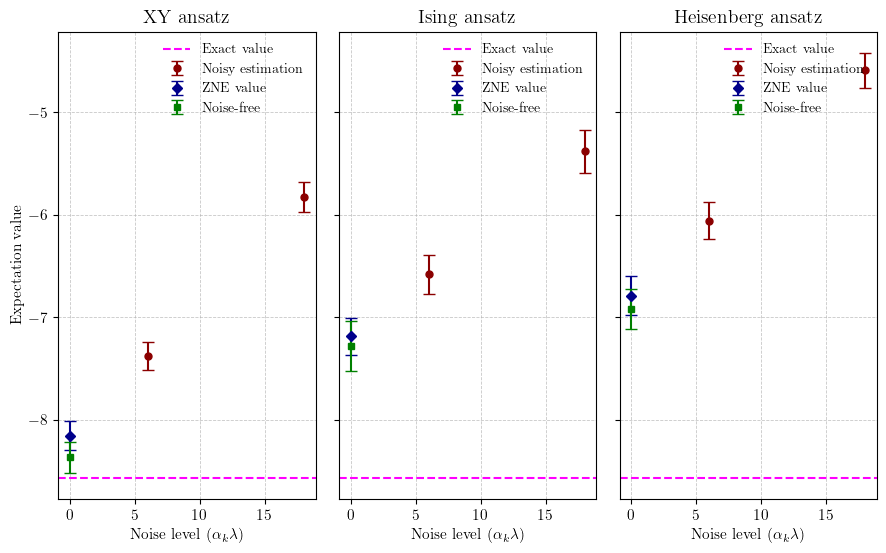

In [19]:
plot_name: str = f"compiled_ric3_ansatz_noise_free_tevo_{timestamp}.eps"
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 6), sharey=True)

plot_titles = {
    "xy": "XY ansatz",
    "heisenberg": "Heisenberg ansatz",
    "ising": "Ising ansatz"
}

for i, model in enumerate(["xy", "ising", "heisenberg"]):
    ax = axs[i]
    DATA = ALL_PROCESSED_DATA[model]

    # Noisy Estimation
    ax.errorbar(
        x=DATA["redundant"]["sorted_noise_levels"],
        y=DATA["redundant"]["mean"],
        yerr=DATA["redundant"]["std"],
        fmt="o",
        ecolor=plot_colors[0],
        capsize=4,
        label="Noisy estimation",
        color=plot_colors[0],
        markersize=5
    )

    # ZNE Extrapolated
    ax.errorbar(
        x=EXTRAPOL_TARGET,
        y=DATA["zne"]["mean"],
        yerr=DATA["zne"]["std"],
        fmt="D",
        ecolor=plot_colors[2],
        capsize=4,
        label="ZNE value",
        color=plot_colors[2],
        markersize=5
    )

    # Noise-free Estimation
    ax.errorbar(
        x=0,
        y=DATA["noiseoff"]["mean"],
        yerr=DATA["noiseoff"]["std"],
        fmt="s",
        ecolor=plot_colors[6],
        capsize=4,
        label="Noise-free",
        color=plot_colors[6],
        markersize=5
    )

    # Exact Value
    ax.axhline(
        y=EXACT_SOL,
        color=plot_colors[5],
        linestyle="--",
        linewidth=1.5,
        label="Exact value"
    )

    # Titles and Labels
    ax.set_title(plot_titles[model], fontsize=14)
    ax.set_xlabel(r"Noise level ($\alpha_k\lambda$)")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)

    if i == 0:
        ax.set_ylabel("Expectation value")

    # ✅ Legend in top right
    ax.legend(loc="upper right", frameon=False)

# Layout tweaks
plt.tight_layout(w_pad=1.2, h_pad=0.3)
plt.subplots_adjust(top=0.88)

# Optional: Save
plt.savefig(f"plots/{plot_name}", format="eps")

plt.show()

## (7) Summary

In [24]:
CONFIG_SUMMARY: dict = {
    "xy": ALL_RAW_DATA["xy"]["vqe"][0]["config"],
    "ising": ALL_RAW_DATA["ising"]["vqe"][0]["config"],
    "heisenberg": ALL_RAW_DATA["heisenberg"]["vqe"][0]["config"],
}

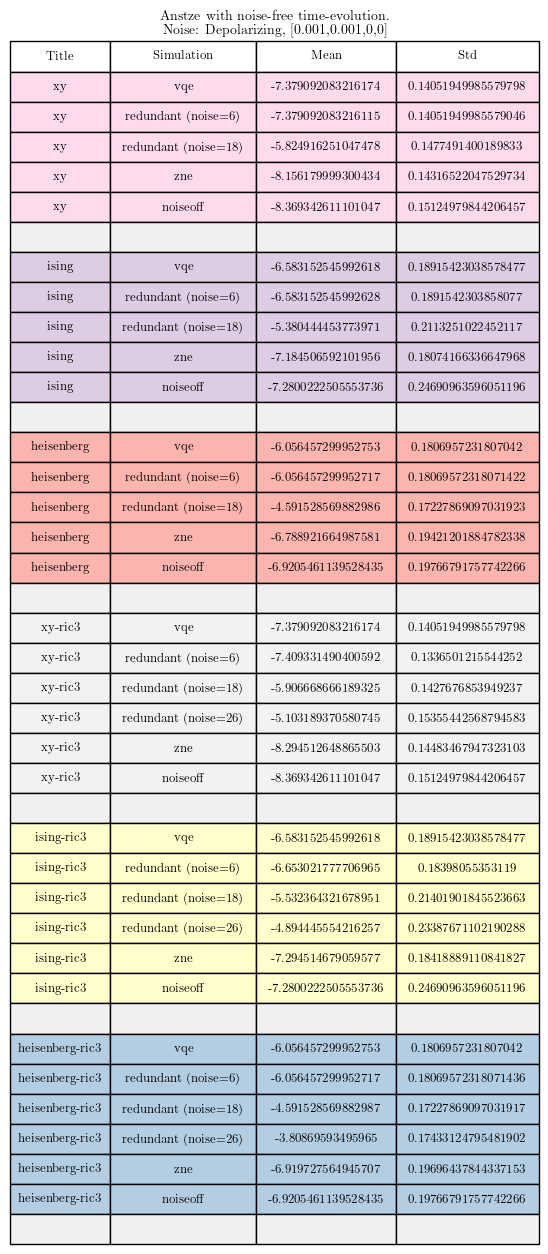

In [25]:
# Prepare rows as before
rows = []
for model, methods in ALL_PROCESSED_DATA.items():
    for method, stats in methods.items():
        if method == "redundant":
            for lvl, m, s in zip(stats['sorted_noise_levels'], stats['mean'], stats['std']):
                rows.append([model, f"{method} (noise={lvl})", m, s])
        elif stats:
            rows.append([model, method, stats['mean'], stats['std']])
        else:
            rows.append([model, method, "N/A", "N/A"])
    rows.append(["", "", "", ""])

df = pd.DataFrame(rows, columns=["Title", "Simulation", "Mean", "Std"])

unique_models = set(m.lower().strip() for m in df["Title"] if m.strip() != "")
colors = cm.Pastel1(np.linspace(0, 1, len(unique_models)))
model_colors = {model.lower(): colors[i] for i, model in enumerate(sorted(unique_models))}



fig, ax = plt.subplots()
ax.axis('off')

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.auto_set_column_width(col=list(range(len(df.columns))))

for i, model_name in enumerate(df["Title"]):
    key = model_name.strip().lower()
    if key == "":
        for j in range(len(df.columns)):
            table[(i + 1, j)].set_facecolor("#f0f0f0")
        continue
    if key in model_colors:
        for j in range(len(df.columns)):
            table[(i + 1, j)].set_facecolor(model_colors[key])

# Draw the canvas and get the bounding box of the table
fig.canvas.draw()
bbox = table.get_window_extent(fig.canvas.get_renderer())

# Convert bbox from display units to inches
bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())

# Resize the figure to tightly fit the table
fig.set_size_inches(bbox_inches.width, bbox_inches.height)
fig.suptitle("Anstze with noise-free time-evolution. \n Noise: Depolarizing, [0.001,0.001,0,0]", fontsize=10, fontweight='bold', y=1.45)
# Remove margins by using add_axes with full figure and redraw
ax.set_position([0, 0, 1, 1])

plt.show()

In [26]:
HEIGHT = 0.2
WIDTH = 5
FILE_NAME = f"result_summary_{timestamp}.pdf"

# Flatten deeply nested dicts
def flatten_config(config, prefix=""):
    flat = {}
    for k, v in config.items():
        full_key = f"{prefix}{k}"
        if isinstance(v, dict):
            flat.update(flatten_config(v, prefix=full_key + "."))
        else:
            flat[full_key] = v
    return flat

def render_model_config_page(model_name, config_dict):
    flat_config = flatten_config(config_dict)
    df = pd.DataFrame(list(flat_config.items()), columns=["Parameter", "Value"])

    # Estimate height dynamically
    row_height = HEIGHT  # inches per row
    max_width = WIDTH  # keep A4 landscape width if needed
    fig_height = max(2, min(len(df) * row_height + 1.5, 11))

    fig = plt.figure(figsize=(max_width, fig_height))
    ax = fig.add_axes([0, 0, 1, 1])  # Full area, no margin
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='left',
        loc='center',
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.3)  # Adjust row height for readability

    # Color header row
    for j in range(len(df.columns)):
        table[(0, j)].set_fontsize(9)
        table[(0, j)].set_facecolor("#dddddd")
        table[(0, j)].set_text_props(weight='bold')

    # Add title manually
    fig.text(0.5, 0.98, f"{model_name.upper()} VQE CONFIGURATION", ha='center', fontsize=12, weight='bold')

    return fig

with PdfPages(FILE_NAME) as pdf:
    # Save a main figure (if any)
    pdf.savefig(fig, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig)
    
    # Save multiple stored figures
    for stored_fig in ALL_PLOTS:
        pdf.savefig(stored_fig, bbox_inches='tight', pad_inches=0.05)
        plt.close(stored_fig)
    
    # Save config summary pages
    for model, config in CONFIG_SUMMARY.items():
        config_fig = render_model_config_page(model, config)
        pdf.savefig(config_fig, bbox_inches='tight', pad_inches=0.1)
        plt.close(config_fig)
    
    print("Result summary saved as PDF:", FILE_NAME)

Result summary saved as PDF: result_summary_20251006-130356.pdf


Latex code generation

In [28]:
# Extract noise levels automatically from first model
first_model = next(iter(ALL_PROCESSED_DATA))
sorted_levels = ALL_PROCESSED_DATA[first_model]["redundant"]["sorted_noise_levels"]

low_noise = sorted_levels[0]
high_noise = sorted_levels[-1]

def format_val(mean, std):
    """Format as mean ± std, or N/A if missing."""
    if isinstance(mean, (float, int)) and isinstance(std, (float, int)):
        return f"${mean:.3f} \\pm {std:.3f}$"
    else:
        return "$\\text{N/A}$"

# Row definition: label → extraction functions (mean, std)
row_blocks = [
    ("Noise-free estimation", 
     lambda d, m: d[m].get("noiseoff", {}).get("mean", "N/A"),
     lambda d, m: d[m].get("noiseoff", {}).get("std", "N/A")),

    (f"Noisy estimation at noise level ${low_noise}$", 
     lambda d, m: get_redundant(d, m, low_noise, "mean"),
     lambda d, m: get_redundant(d, m, low_noise, "std")),

    (f"Boosted noisy estimation at noise level ${high_noise}$", 
     lambda d, m: get_redundant(d, m, high_noise, "mean"),
     lambda d, m: get_redundant(d, m, high_noise, "std")),

    ("Richardson ZNE value", 
     lambda d, m: d[m].get("zne", {}).get("mean", "N/A"),
     lambda d, m: d[m].get("zne", {}).get("std", "N/A")),
]

# LaTeX header
latex = r"""\begin{table}[h]
\caption{Result summary for Richardson ZNE where the ansatz has noise-free time evolution. The corresponding graphs are plotted in Figure \ref{graph-noisefree-timevo}.}
\begin{tabular}{@{}llll@{}}
\toprule
  & XY-ansatz  & Ising-ansatz  & Heisenberg-ansatz\\
\midrule
"""

# Row generation
for i, (label, mean_fn, std_fn) in enumerate(row_blocks):
    row = [label]
    for col in models.values():
        mean_val = mean_fn(ALL_PROCESSED_DATA, col)
        std_val = std_fn(ALL_PROCESSED_DATA, col)
        row.append(format_val(mean_val, std_val))
    latex += " & ".join(row) + r" \\" + "\n"

    if i in [0, 2]:
        latex += r"\midrule" + "\n"

latex += r"""\bottomrule
\end{tabular}
\label{table-noisefree-timeevo-richardson}
\end{table}
"""

print(latex)

NameError: name 'models' is not defined